In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

gpytorch.functions.use_toeplitz = False
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from torch.autograd import Variable

n = 201
train_x = torch.zeros(n ** 2, 2)
train_x[:, 0].copy_(torch.linspace(-1, 1, n).repeat(n))
train_x[:, 1].copy_(torch.linspace(-1, 1, n).unsqueeze(1).repeat(1, n).view(-1))
train_y = (train_x[:, 0].abs().lt(0.5)).float() * (train_x[:, 1].abs().lt(0.5)).float() * 2 - 1

train_x = Variable(train_x).cuda()
train_y = Variable(train_y).cuda()

In [3]:
from torch import nn, optim
from gpytorch.kernels import RBFKernel, GridInterpolationKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood, BernoulliLikelihood
from gpytorch.random_variables import GaussianRandomVariable

In [4]:
class LatentFunction(gpytorch.AdditiveGridInducingPointModule):
    def __init__(self):
        super(LatentFunction, self).__init__(grid_size=100, grid_bounds=[(-1, 1)])
        self.mean_module = ConstantMean(constant_bounds=[-1e-5, 1e-5])
        self.covar_module = RBFKernel(log_lengthscale_bounds=(-5, 6))
        self.register_parameter('log_outputscale', nn.Parameter(torch.Tensor([0])), bounds=(-5,6))
        
    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        covar_x = covar_x.mul(self.log_outputscale.exp())
        latent_pred = GaussianRandomVariable(mean_x, covar_x)
        return latent_pred

class GPClassificationModel(gpytorch.GPModel):
    def __init__(self):
        super(GPClassificationModel,self).__init__(BernoulliLikelihood())
        self.latent_function = LatentFunction()
        
    def forward(self, x):
        return self.latent_function(x)

model = GPClassificationModel().cuda()

In [5]:
# Find optimal model hyperparameters
model.train()
optimizer = optim.Adam(model.parameters(), lr=0.2)
optimizer.n_iter = 0
for i in range(200):
    optimizer.zero_grad()
    output = model.forward(train_x)
    loss = -model.marginal_log_likelihood(output, train_y)
    loss.backward()
    optimizer.n_iter += 1
    print('Iter %d/200 - Loss: %.3f   log_lengthscale: %.3f' % (
        i + 1, loss.data[0],
        model.latent_function.covar_module.base_kernel_module.log_lengthscale.data.squeeze()[0],
    ))
    optimizer.step()
    
# Set back to eval mode
model.eval()

Iter 1/200 - Loss: 499913.438   log_lengthscale: 0.000
Iter 2/200 - Loss: 635771.875   log_lengthscale: -0.200
Iter 3/200 - Loss: 123735.375   log_lengthscale: -0.370
Iter 4/200 - Loss: 106162.734   log_lengthscale: -0.552
Iter 5/200 - Loss: 193994.719   log_lengthscale: -0.719
Iter 6/200 - Loss: 167296.266   log_lengthscale: -0.893
Iter 7/200 - Loss: 59731.820   log_lengthscale: -1.076
Iter 8/200 - Loss: 33765.285   log_lengthscale: -1.248
Iter 9/200 - Loss: 29404.930   log_lengthscale: -1.413
Iter 10/200 - Loss: 28385.047   log_lengthscale: -1.571
Iter 11/200 - Loss: 35645.172   log_lengthscale: -1.721
Iter 12/200 - Loss: 51547.586   log_lengthscale: -1.867
Iter 13/200 - Loss: 39891.703   log_lengthscale: -2.009
Iter 14/200 - Loss: 37637.531   log_lengthscale: -2.155
Iter 15/200 - Loss: 53581.992   log_lengthscale: -2.294
Iter 16/200 - Loss: 31955.320   log_lengthscale: -2.426
Iter 17/200 - Loss: 30411.990   log_lengthscale: -2.554
Iter 18/200 - Loss: 35903.523   log_lengthscale: -2.

GPClassificationModel (
  (likelihood): BernoulliLikelihood (
  )
  (latent_function): LatentFunction (
    (mean_module): ConstantMean (
    )
    (covar_module): GridInterpolationKernel (
      (base_kernel_module): RBFKernel (
      )
    )
  )
)

In [6]:
def plot_model_and_predictions(model, plot_train_data=True):
    f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
    n = 100
    test_x = torch.zeros(n ** 2, 2)
    test_x[:, 0].copy_(torch.linspace(-1, 1, n).repeat(n))
    test_x[:, 1].copy_(torch.linspace(-1, 1, n).unsqueeze(1).repeat(1, n).view(-1))
    test_x = Variable(test_x).cuda()
    observed_pred = model(test_x)

    def ax_plot(ax, rand_var, title):
        pred_labels = rand_var.mean().ge(0.5).float().mul(2).sub(1).data.cpu().numpy()
        color = []
        for i in range(len(pred_labels)):
            if pred_labels[i] == 1:
                color.append('y')
            else:
                color.append('r')
        ax.scatter(test_x.data[:, 0].cpu().numpy(), test_x.data[:, 1].cpu().numpy(), color=color, s=1)
        ax.set_ylim([-1, 1])
        ax.set_title(title)
    
    ax_plot(observed_ax, observed_pred, 'Predicted Values')    
    return f

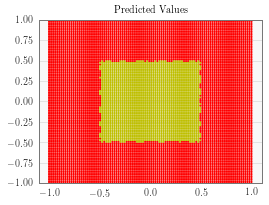

In [7]:
f = plot_model_and_predictions(model)